In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif, RFECV
from scipy.stats import ttest_rel, chi2_contingency, shapiro
from warnings import filterwarnings
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

np.set_printoptions(suppress=True)
filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 3)

In [3]:
disease = pd.read_csv('data.csv') 

In [4]:
df = disease.copy()

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# Configs

In [5]:
name_map = {'cp': 'ChestPainType', 'sex':'Sex', 'thalach': 'HeartRate', 'age': 'Age',
 'trestbps': 'RestTimeBloodPressure', 'chol': 'TotalCholesterol', 'fbs':'BloodSugar', 
 'restecg': 'ECG_Results', 'thalach': 'MaxHeartRate', 'exang': 'ExerciseInducedAngina',
 'oldpeak': 'STDepression', 'slope': 'Slope', 'ca': 'NumVessels', 'thal': 'Thal', 'target':'Target'}

df = df.rename(name_map, axis=1)

TARGET = 'Target'
integer_columns = [name_map['age'], name_map['trestbps'], name_map['chol'],name_map['thalach']]
float_columns = [name_map['oldpeak']]
continuous_columns = integer_columns + float_columns
discrete_columns = list(set(df.columns) - set(integer_columns + float_columns + [TARGET])) 


# chol > 200 -> disease
# high fbs -> disease
# restecg(electrocardiographic results) -> used with other test to diagnose heart disease
# 60 < thalach < 100 else bad
# exang -> symptom for heart disease
# oldpeak -> symptom for heart disease
# high ca -> disease
# thal:  3 = normal; 6 = fixed defect; 7 = reversable defect (from docs)

SAMPLE_SIZE = 100
TEST_SIGNIFICANCE_VALUE = 0.05

# TASK: Minimize TN rate.

# EDA
### Univariate Analysis

In [23]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestTimeBloodPressure',
       'TotalCholesterol', 'BloodSugar', 'ECG_Results', 'MaxHeartRate',
       'ExerciseInducedAngina', 'STDepression', 'Slope', 'NumVessels', 'Thal',
       'Target'],
      dtype='object')

In [6]:
df[integer_columns] = df[integer_columns].astype(np.int32)
df[float_columns] = df[float_columns].astype(np.float32)
df[discrete_columns] = df[discrete_columns].astype(np.int8)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    303 non-null    int32  
 1   Sex                    303 non-null    int8   
 2   ChestPainType          303 non-null    int8   
 3   RestTimeBloodPressure  303 non-null    int32  
 4   TotalCholesterol       303 non-null    int32  
 5   BloodSugar             303 non-null    int8   
 6   ECG_Results            303 non-null    int8   
 7   MaxHeartRate           303 non-null    int32  
 8   ExerciseInducedAngina  303 non-null    int8   
 9   STDepression           303 non-null    float32
 10  Slope                  303 non-null    int8   
 11  NumVessels             303 non-null    int8   
 12  Thal                   303 non-null    int8   
 13  Target                 303 non-null    int64  
dtypes: float32(1), int32(4), int64(1), int8(8)
memory usage: 1

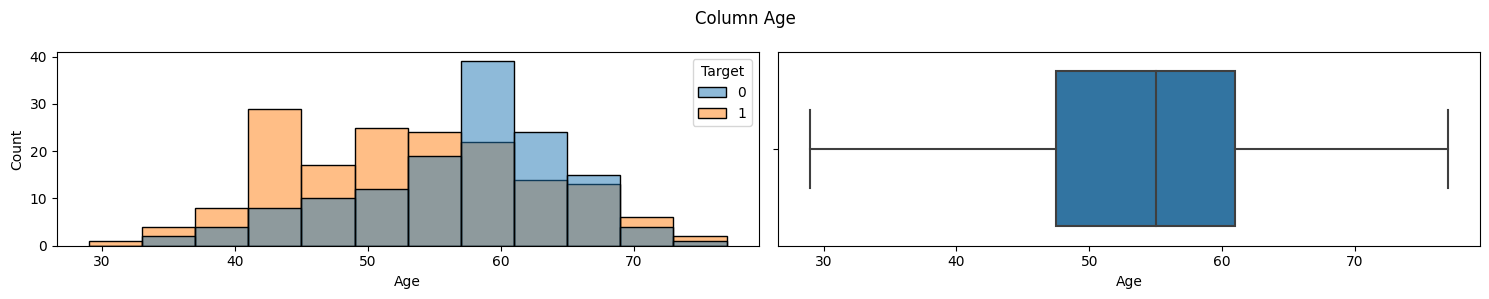

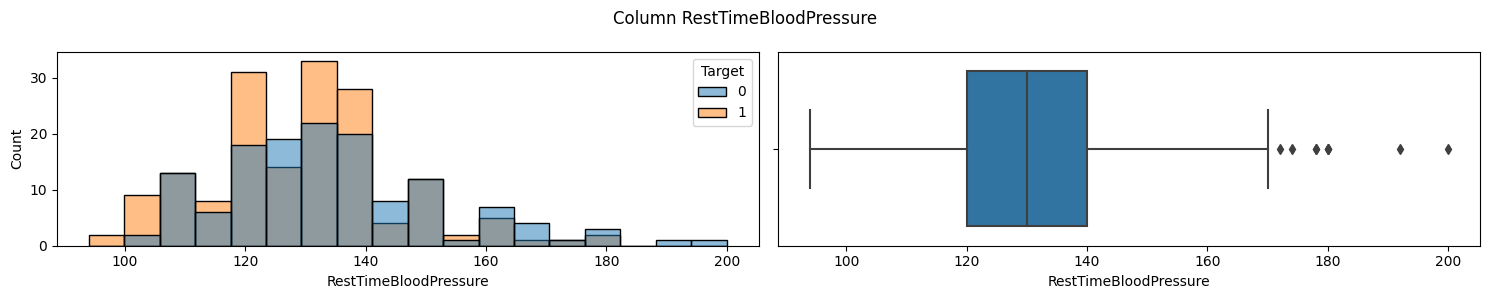

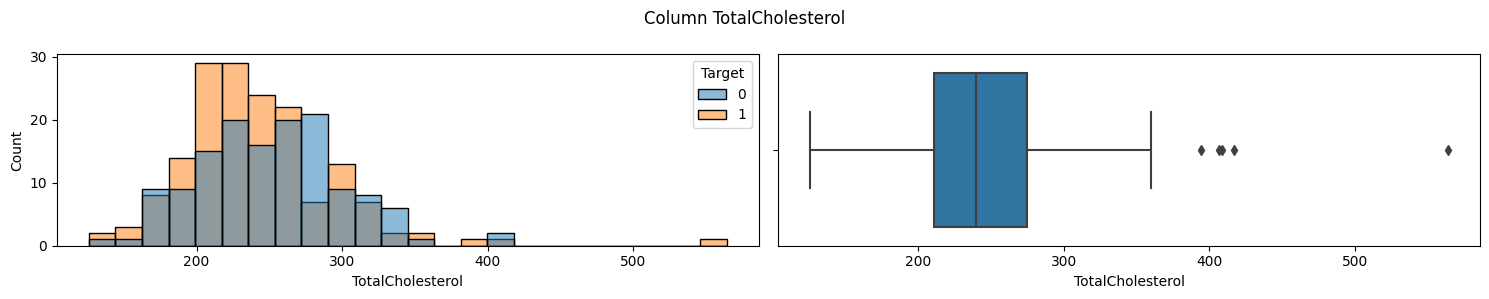

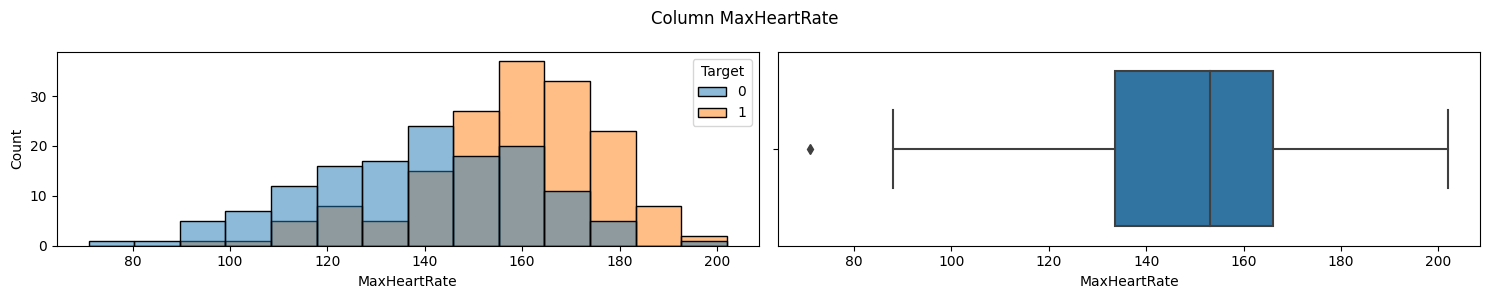

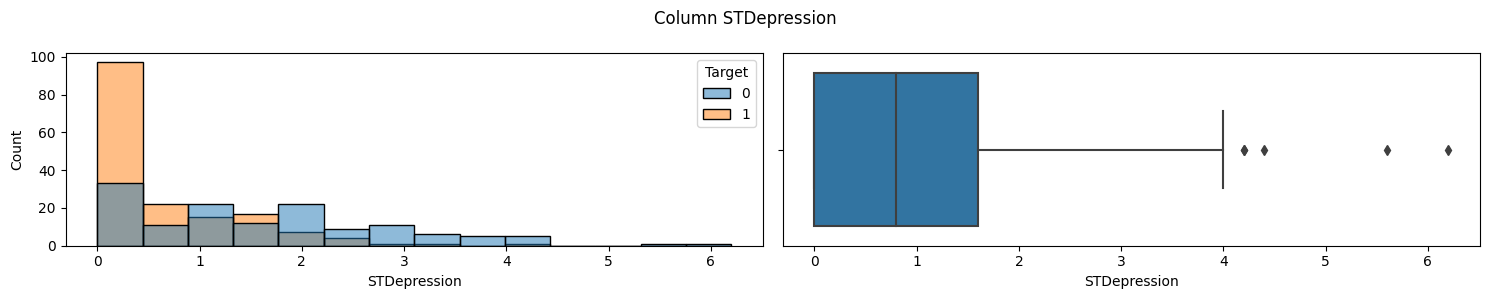

In [58]:
def cont_plots(df, col, target=None):
    m = 1
    n = 2
    fig = plt.figure(figsize=(15,3))
    plt.subplot(m, n, 1)
    sns.histplot(data=df, x=col, hue=target)
    plt.subplot(m, n, 2)
    sns.boxplot(data=df, x=col)
    plt.suptitle(f'Column {col}')
    plt.tight_layout()
    plt.show()

for col in continuous_columns:
    cont_plots(df, col, TARGET)

In [356]:
discrete_columns

['ECG_Results',
 'Sex',
 'ChestPainType',
 'Slope',
 'Thal',
 'ExerciseInducedAngina',
 'BloodSugar',
 'NumVessels']

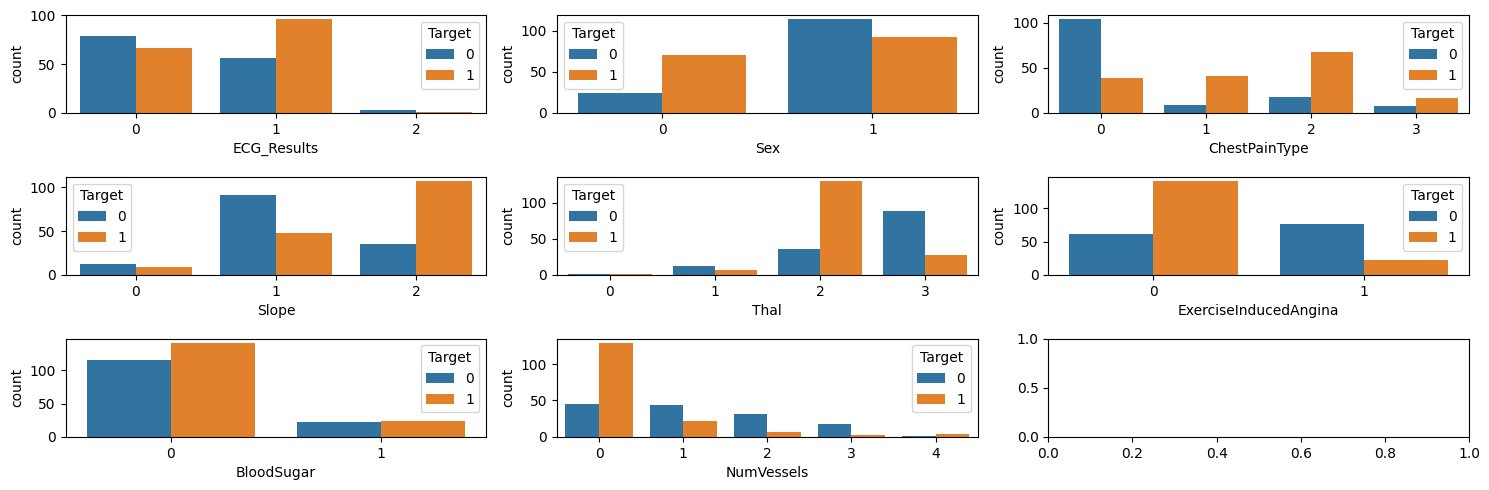

In [365]:
m = 3
n = 3

fig, ax = plt.subplots(m, n, figsize=(15,5))
col_idx = 0
for row in range(m):
    for i in range(n):
        try:
            sns.countplot(data=df, x=discrete_columns[col_idx], ax=ax[row][i], hue=TARGET)
        except IndexError:
            break
        col_idx+=1
plt.tight_layout()
    
# Most of the Columns have an impact of the dependant variable
# ECG 1 -> more likely to have disease
# Gender 0 (Female) -> more likely to have disease
# ChestPainType 1,2 -> more likely to have disease
# Slope 2 -> more likely to have disease
# Thal 2 -> more likely to have disease
# ExcerciseInducedAngina 0 -> more likely to have disease
# BloodSugar -> No impact?
# NumVessels 0 -> more likely to have disease



<AxesSubplot: xlabel='Target', ylabel='count'>

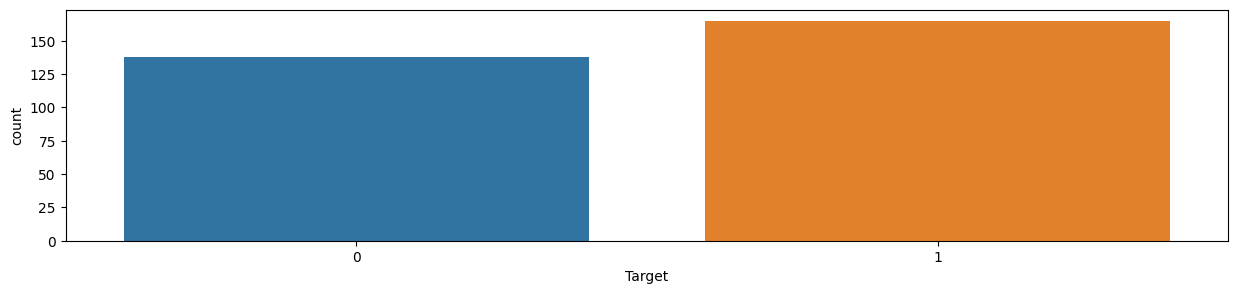

In [55]:
sns.countplot(data=df, x=TARGET);

# balanced dataset

# Bivariate Analysis
### Continuous Variable Analysis

In [63]:
continuous_columns

['Age',
 'RestTimeBloodPressure',
 'TotalCholesterol',
 'MaxHeartRate',
 'STDepression']

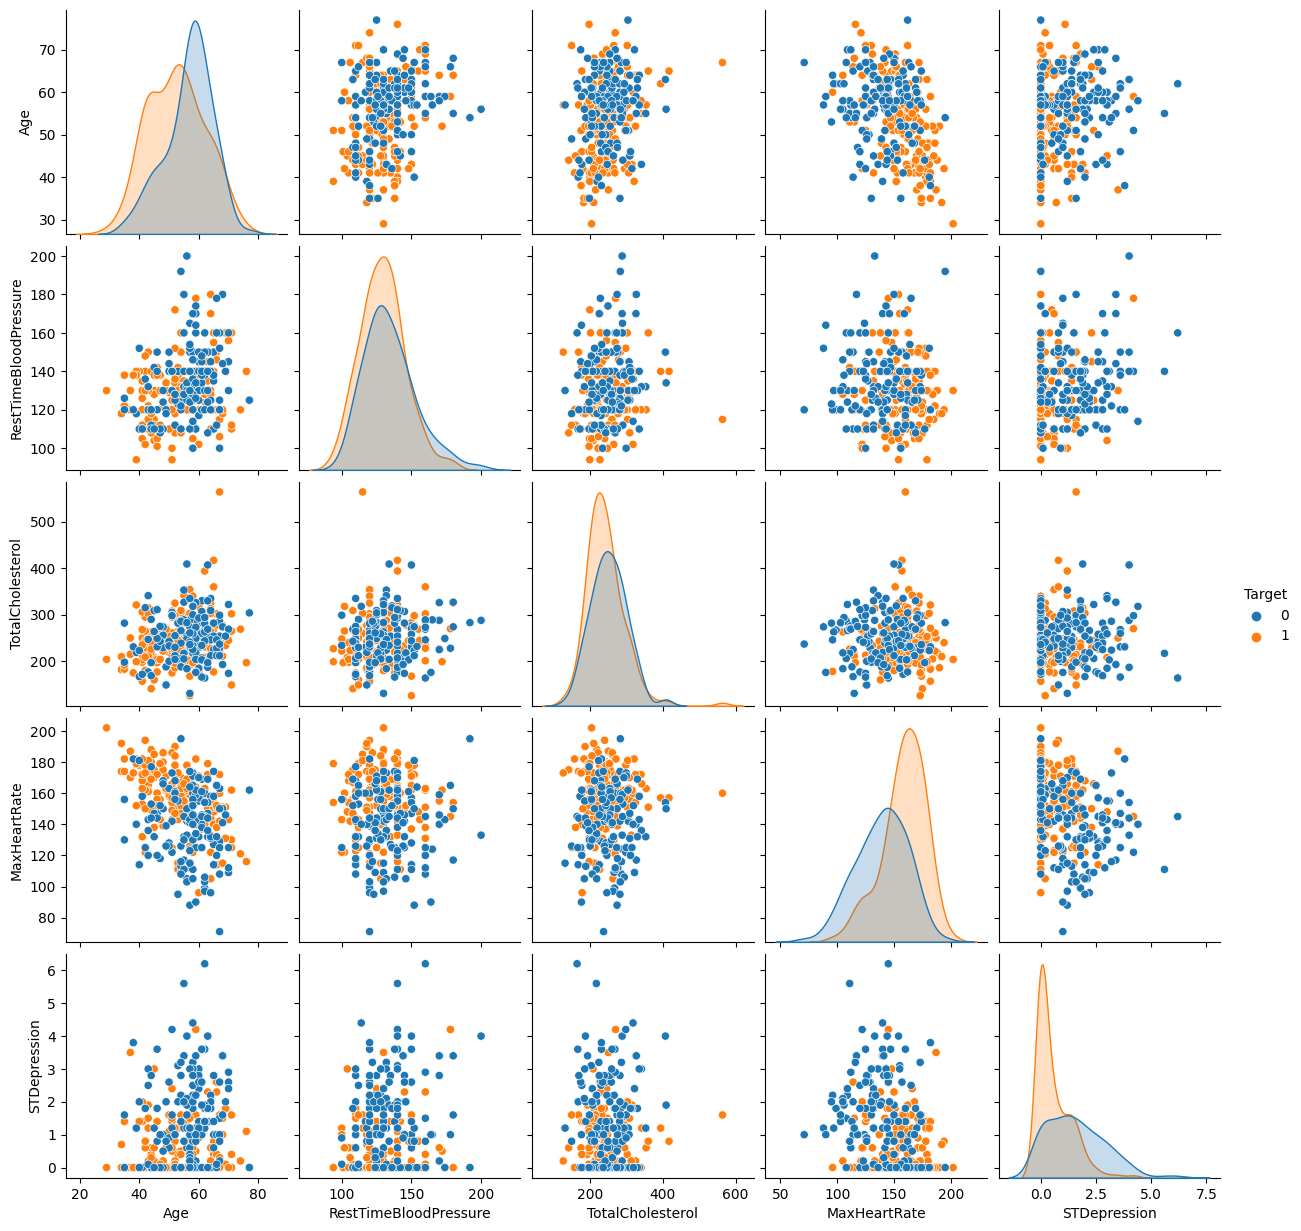

In [68]:
sns.pairplot(data=df[continuous_columns+ [TARGET]] , hue=TARGET)

# Age - BloodPressure positively correlated?
# Age - MaxHeartRate negatively correlated?
# Age - BloodPressure correlated?

# STD_Depression - right skewed


<AxesSubplot: >

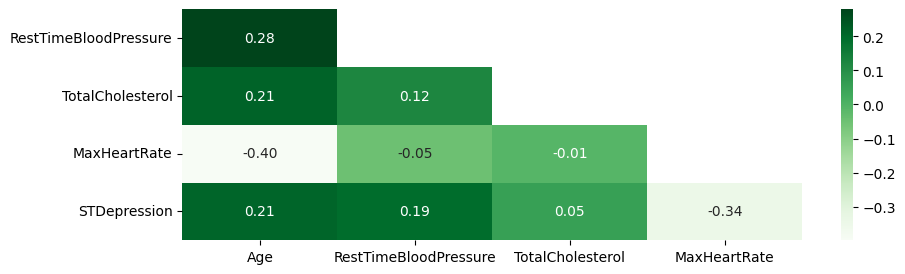

In [128]:
cor= df[continuous_columns].corr()
mask = np.triu(np.ones_like(cor))[1:, :-1]
cor = cor.iloc[1:, :-1].copy()
sns.heatmap(cor, annot=True, cmap='Greens', mask=mask, fmt='.2f')

In [195]:
# h0 - Means in each group are the same
# ha - Means in each group are not the same

def anova_test(df, relative_to=TARGET):
    test, pval = f_classif(df[continuous_columns], df[relative_to])
    for idx, col in enumerate(continuous_columns):
        decision = ('no', '❌') if pval[idx] > TEST_SIGNIFICANCE_VALUE else ('an', '✅') 
        print(f'Column {col} has {decision[0]} impact on \'{relative_to}\' {decision[1]}' )


def ttest(df, relative_to=TARGET):
    for i in continuous_columns:
        test, pval = ttest_rel(df[relative_to], df[i])
        decision = ('no', '❌') if pval> TEST_SIGNIFICANCE_VALUE else ('an', '✅')
        print(f'Column {i} has {decision[0]} impact on \'{relative_to}\' {decision[1]}' )

anova_test(df)


Column Age has an impact on 'Target' ✅
Column RestTimeBloodPressure has an impact on 'Target' ✅
Column TotalCholesterol has no impact on 'Target' ❌
Column MaxHeartRate has an impact on 'Target' ✅
Column STDepression has an impact on 'Target' ✅


### Discrete variable analysis

In [387]:
# h0 - feature has no impact on other feature
# ha - feature has an impact on other feature

def cramer_v(df, relative_to_target=False):
    rows, columns = df.shape
    results = []
    mask = None
    if relative_to_target:
        for idx, col in enumerate(discrete_columns):
            crosstab = pd.crosstab(df[col], df[TARGET])
            chi_2, pval, dof, _ = chi2_contingency(crosstab)
            cramer = -1 if pval > TEST_SIGNIFICANCE_VALUE else np.sqrt(chi_2/(rows*(columns-1)))
            results.append((cramer, pval, dof))
        results = pd.DataFrame(results, columns=('Test', 'Pval', 'Dof'), index=discrete_columns, dtype=np.float16) \
                                .sort_values('Test', ascending=False)
        print(results)
        
    else:
        for idx, col in enumerate(discrete_columns):
            results.append([])
            for inner_col in discrete_columns:
                crosstab = pd.crosstab(df[col], df[inner_col])
                chi_2, pval, dof, _ = chi2_contingency(crosstab)
                cramer = -1 if pval > TEST_SIGNIFICANCE_VALUE else np.sqrt(chi_2/(rows*(columns-1)))
                results[idx].append(cramer)
        cor = pd.DataFrame(results, columns=discrete_columns, index=discrete_columns)
        mask = np.triu(np.ones_like(cor, dtype=bool))[1:, :-1]
        cor = cor.iloc[1:, :-1]
        sns.heatmap(cor, annot=True, fmt='.2f', cbar=True, cmap='Greens', mask=None or mask)
        plt.show();

cramer_v(df, relative_to_target=True)

# Indeed, Chi2 test says BloodSugar has no relationship to Target variable



                        Test  Pval   Dof
Thal                   0.149 0.000 3.000
ChestPainType          0.144 0.000 3.000
NumVessels             0.137 0.000 4.000
ExerciseInducedAngina  0.119 0.000 1.000
Slope                  0.111 0.000 2.000
Sex                    0.075 0.000 1.000
ECG_Results            0.051 0.006 2.000
BloodSugar            -1.000 0.761 1.000


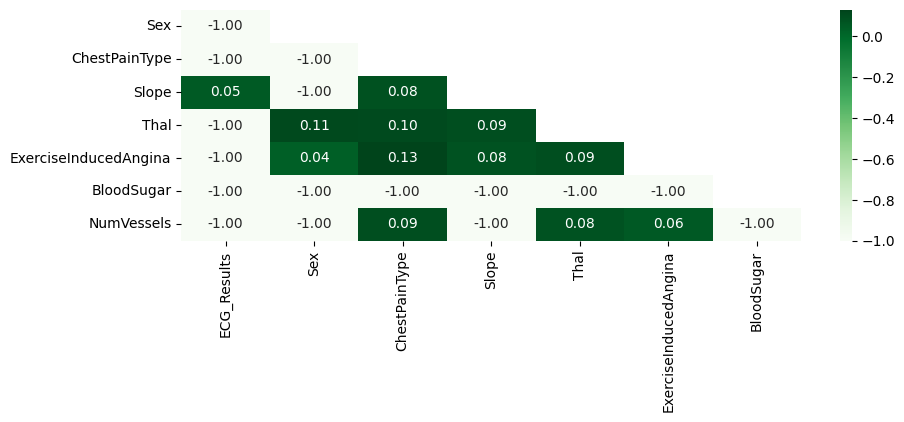

In [388]:
cramer_v(df, relative_to_target=False)
# Drop ECG_Results?

# Base Model

In [425]:
X, y = df.drop(TARGET, axis=1), df[TARGET]


clf= LogisticRegression()
metric = 'accuracy'
score = cross_val_score(clf, X, y, scoring=metric, cv=5).mean() 
print(f'{metric.capitalize()}: {score}')

Accuracy: 0.8281967213114754


# Fixing Skewed Distributions

In [273]:
# h0 - the columns are normally distributed
# ha - the columns are not normally distributed

def shaport_wilk_test(df):
    for col in continuous_columns:
        _, pval = shapiro(df[col])
        decision = ('is', '✅')  if pval > TEST_SIGNIFICANCE_VALUE else ('is not', '❌') 
        print(f'Column {col} {decision[0]} normally distributed {decision[1]}' )


shaport_wilk_test(df)


Column Age is not normally distributed ❌
Column RestTimeBloodPressure is not normally distributed ❌
Column TotalCholesterol is not normally distributed ❌
Column MaxHeartRate is not normally distributed ❌
Column STDepression is not normally distributed ❌


# Outlier Handling

In [7]:
df = df[df['TotalCholesterol']<500]

In [9]:
# RESULT TEST

X, y = df.drop(TARGET, axis=1), df[TARGET]

def evaluate(X, y, clf=LogisticRegression(), metric='accuracy'):
    score = cross_val_score(clf, X, y, scoring=metric, cv=5).mean() 
    print(f'{metric.capitalize()}: {score}')

evaluate(X, y)

Accuracy: 0.8376502732240437


In [354]:
df

,Age,Sex,ChestPainType,RestTimeBloodPressure,TotalCholesterol,BloodSugar,ECG_Results,MaxHeartRate,ExerciseInducedAngina,STDepression,Slope,NumVessels,Thal,Target
0,63,1,3,145,233,1,0,150,0,2.300,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.400,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.800,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.600,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.200,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.200,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.400,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.200,1,1,3,0


In [390]:
# df_tr = df.drop('BloodSugar', axis=1)
X, y = df.drop(TARGET, axis=1), df[TARGET]
evaluate(X, y)

Accuracy: 0.8376502732240437


In [8]:
X, y = df.drop(TARGET, axis=1), df[TARGET]
for i in range(2, df.shape[1]):
    pca = PCA(n_components=i)
    X_tr = pca.fit_transform(X,y)
    print(f'{i} components: ', end='')
    evaluate(X_tr, y)

2 components: 

NameError: name 'evaluate' is not defined

In [10]:
n_components = 8

pca = PCA(n_components=n_components)
X_tr = pca.fit_transform(X,y)
component_value = pd.DataFrame(pca.components_,columns=X.columns, index = [f'PC-{i}' for i in range(1, n_components + 1)])
component_value

,Age,Sex,ChestPainType,RestTimeBloodPressure,TotalCholesterol,BloodSugar,ECG_Results,MaxHeartRate,ExerciseInducedAngina,STDepression,Slope,NumVessels,Thal
PC-1,0.039943,-0.001730,-0.002227,0.063805,0.997044,0.000207,-0.001544,-0.014788,0.000882,0.001323,0.000037,0.002026,0.001051
PC-2,0.181710,0.000802,-0.012404,0.095766,-0.027993,0.000425,-0.001183,-0.977894,0.007496,0.017935,-0.010475,0.009963,0.002616
PC-3,0.129406,-0.001087,0.006670,0.981705,-0.066209,0.003642,-0.002748,0.122246,-0.000141,0.009590,-0.002604,0.003917,0.001366
PC-4,0.973600,-0.004589,0.008580,-0.151088,-0.026891,0.003465,-0.002901,0.166896,-0.006863,-0.001168,0.003525,0.022826,-0.001049
PC-5,-0.009493,0.078181,-0.330679,-0.009733,-0.001435,-0.001533,-0.026349,0.024041,0.111487,0.784821,-0.232713,0.417039,0.163179
PC-6,0.004322,-0.028410,0.703857,-0.008383,0.002250,-0.000403,0.016198,-0.002949,-0.070476,0.499683,-0.207152,-0.450039,-0.057585
PC-7,-0.023617,0.045758,0.595492,-0.001736,0.001024,0.068327,-0.003830,-0.008276,-0.117246,-0.117314,0.093893,0.775434,-0.018951
PC-8,-0.004368,-0.306725,-0.131545,0.000442,0.000029,0.020734,-0.030973,0.001268,-0.121106,0.094565,-0.108669,0.103761,-0.917072


In [11]:
n_pcs =pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [df.columns[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
most_important = pd.DataFrame(sorted(dic.items()))
most_important

,0,1
0,PC1,TotalCholesterol
1,PC2,MaxHeartRate
2,PC3,RestTimeBloodPressure
3,PC4,Age
4,PC5,STDepression
5,PC6,ChestPainType
6,PC7,NumVessels
7,PC8,Thal


In [12]:
X_tr = pd.DataFrame(X_tr, columns=most_important[1].values)
df_tr = pd.concat([X_tr, y], join='inner', axis=1)
df_tr.head()

,TotalCholesterol,MaxHeartRate,RestTimeBloodPressure,Age,STDepression,ChestPainType,NumVessels,Thal,Target
0,-10.990681,2.815259,15.084971,6.827864,-0.060439,2.661509,0.259744,1.075686,1
1,3.419427,-39.968732,0.392222,-10.518801,2.608325,2.458809,-0.216322,0.506282,1
2,-42.060205,-23.331614,2.093567,-7.882431,0.441027,0.261548,-0.437053,0.521776,1
3,-10.286504,-28.337918,-7.177175,8.366517,0.075239,0.152486,-0.678510,0.065929,1
4,107.631020,-16.775506,-16.701726,3.652882,-0.257126,-0.379317,-1.192146,0.344189,1


<AxesSubplot: >

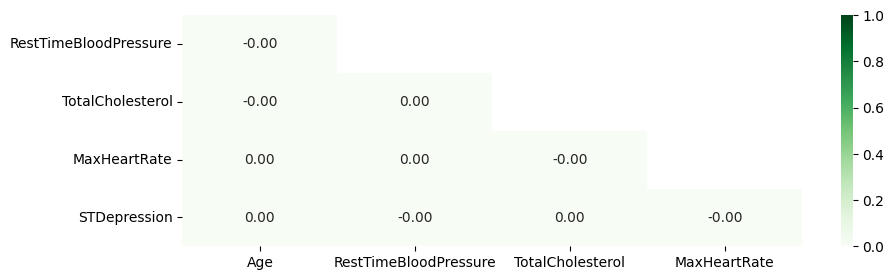

In [454]:
cor= df_tr[continuous_columns].corr()
mask = np.triu(np.ones_like(cor))[1:, :-1]
cor = cor.iloc[1:, :-1].copy()
sns.heatmap(cor, annot=True, cmap='Greens', mask=mask, fmt='.2f', vmin=0, vmax=1) # great :)

# Feature Selection

### Filter method

In [459]:
X, y = df_tr.drop(TARGET, axis=1), df_tr[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.76      0.83        29
           1       0.81      0.94      0.87        32

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



<BarContainer object of 8 artists>

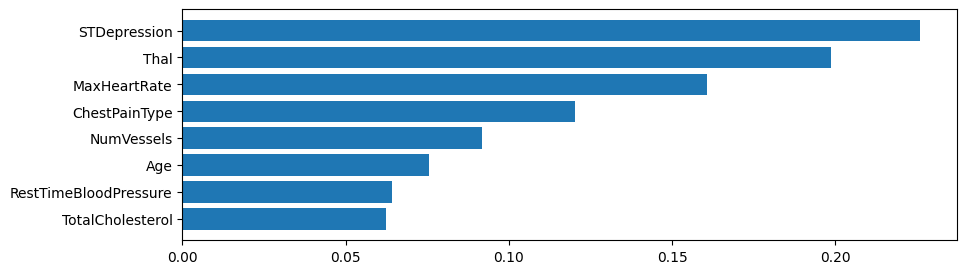

In [465]:
rf_feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.barh(rf_feature_imp.index, rf_feature_imp.values)


### Permutation Importance

<BarContainer object of 8 artists>

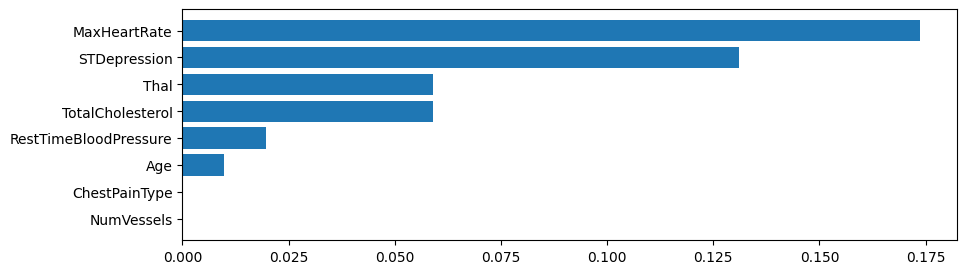

In [472]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
permutation_feature_imp = permutation_importance(clf, X_test, y_test, random_state=1)
permutation_feature_imp = pd.Series(permutation_feature_imp['importances_mean'], index=X.columns).sort_values(ascending=True)
plt.barh(permutation_feature_imp.index, permutation_feature_imp.values)


<BarContainer object of 8 artists>

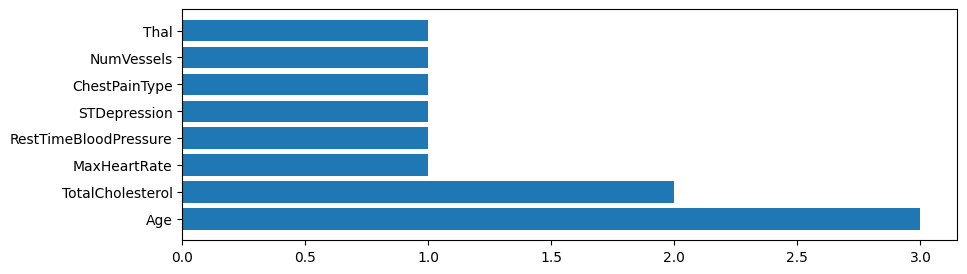

In [509]:

clf = LogisticRegression()
rfe = RFECV(clf)
rfe.fit(X_tr, y)
rfe_feature_imp = pd.Series(rfe.ranking_ ,index=X_tr.columns, name='Ranked Features (1-best)').sort_values(ascending=False)

plt.barh(rfe_feature_imp.index, rfe_feature_imp.values)



In [17]:
X, y = df_tr.drop(TARGET, axis=1), df_tr[TARGET]
TREE_DEPTH = 500
REGULARIZATION_STRENGTH = 20

models = {
    "knn":{
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': range(3, 31, 2),
        }  
    },
    "rf":{
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': range(50, 400),
            'max_depth': range(50,TREE_DEPTH,50)
        },
    
    },
    "dt":{
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini'],
            'max_depth': range(50,TREE_DEPTH,50)
        },  
    },
    
    "lr":{
        'model': LogisticRegression(),
        'params': {
            'C': np.linspace(0, REGULARIZATION_STRENGTH, 30),
            'penalty': ['l1', 'l2']
            },
        },
    "lgbm":{
    'model': LGBMClassifier(),
    'params': {
        'reg_alpha ': np.linspace(0, REGULARIZATION_STRENGTH, 30),
        'reg_lambda ': np.linspace(0, REGULARIZATION_STRENGTH, 30),
        'max_depth': range(50,TREE_DEPTH,50),
        'n_estimators': range(50, 400),
        },
    },
    "NB":{
    'model': GaussianNB(),
    'params': {},        
    },
}


scores = []
for model_name, dct in models.items():
    gs = RandomizedSearchCV(dct['model'], dct['params'], cv=5)
    score = gs.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': score.best_score_,
        'best_params': score.best_params_
    })

scores



[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] Unknown parameter: 11.03448275862069
[LightGBM] [Warning] Unknown parameter: 12.413793103448278
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] Unknown parameter: 11.03448275862069
[LightGBM] [Warning] Unknown parameter: 12.413793103448278
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] Unknown parameter: 11.03448275862069
[LightGBM] [Warning] Unknown parameter: 12.413793103448278
[LightGBM] [Warning] reg_lambda is set=0

[{'model': 'knn',
  'best_score': 0.6579234972677596,
  'best_params': {'n_neighbors': 11}},
 {'model': 'rf',
  'best_score': 0.8404918032786884,
  'best_params': {'n_estimators': 188, 'max_depth': 450}},
 {'model': 'dt',
  'best_score': 0.7737704918032787,
  'best_params': {'max_depth': 100, 'criterion': 'gini'}},
 {'model': 'lr',
  'best_score': 0.8439344262295082,
  'best_params': {'penalty': 'l2', 'C': 20.0}},
 {'model': 'lgbm',
  'best_score': 0.7872677595628416,
  'best_params': {'reg_lambda ': 6.206896551724139,
   'reg_alpha ': 11.724137931034484,
   'n_estimators': 105,
   'max_depth': 300}},
 {'model': 'NB', 'best_score': 0.7907103825136612, 'best_params': {}}]

In [18]:

sc = StandardScaler()
scores = []
for model_name, dct in models.items():
    gs = RandomizedSearchCV(dct['model'], dct['params'], cv=5)
    pip = Pipeline(steps=(
        ('sc', sc),
        ('gs', gs)
    ))
    score = pip.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': score['gs'].best_score_,
        'best_params': score['gs'].best_params_
    })

scores



[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] Unknown parameter: 11.724137931034484
[LightGBM] [Warning] Unknown parameter: 4.137931034482759
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] Unknown parameter: 11.724137931034484
[LightGBM] [Warning] Unknown parameter: 4.137931034482759
[LightGBM] [Warning] reg_lambda is set=0.0, reg_lambda= will be ignored. Current value: reg_lambda=0.0
[LightGBM] [Warning] reg_alpha is set=0.0, reg_alpha= will be ignored. Current value: reg_alpha=0.0
[LightGBM] [Warning] Unknown parameter: 11.724137931034484
[LightGBM] [Warning] Unknown parameter: 4.137931034482759
[LightGBM] [Warning] reg_lambda is set=0

[{'model': 'knn',
  'best_score': 0.8072131147540984,
  'best_params': {'n_neighbors': 17}},
 {'model': 'rf',
  'best_score': 0.8404371584699455,
  'best_params': {'n_estimators': 287, 'max_depth': 50}},
 {'model': 'dt',
  'best_score': 0.7837704918032787,
  'best_params': {'max_depth': 400, 'criterion': 'gini'}},
 {'model': 'lr',
  'best_score': 0.8439344262295082,
  'best_params': {'penalty': 'l2', 'C': 6.8965517241379315}},
 {'model': 'lgbm',
  'best_score': 0.7839890710382513,
  'best_params': {'reg_lambda ': 5.517241379310345,
   'reg_alpha ': 6.8965517241379315,
   'n_estimators': 134,
   'max_depth': 400}},
 {'model': 'NB', 'best_score': 0.7907103825136612, 'best_params': {}}]

In [40]:

rf_kwargs = {'n_estimators': 287, 'max_depth': 50}
lg_kwargs = {'penalty': 'l2', 'C': 6.8965517241379315}
knn_kwargs = {'n_neighbors': 17}

chosen_models = (RandomForestClassifier(**rf_kwargs), 
                LogisticRegression(**lg_kwargs), 
                KNeighborsClassifier(**knn_kwargs))
lr = chosen_models[1]
pip = Pipeline(steps=(
        ('sc', sc),
        ('model', lr)
    ))

df__temp = df_tr.drop('Age', axis=1)
X, y = df__temp.drop(TARGET, axis=1), df__temp[TARGET]
evaluate(X, y, pip)
# Not dropping.


In [34]:

X, y = df_tr.drop(TARGET, axis=1), df_tr[TARGET]
evaluate(X, y, pip)


Accuracy: 0.8338251366120218


0.8333333333333334
0.8333333333333334
0.8333333333333334


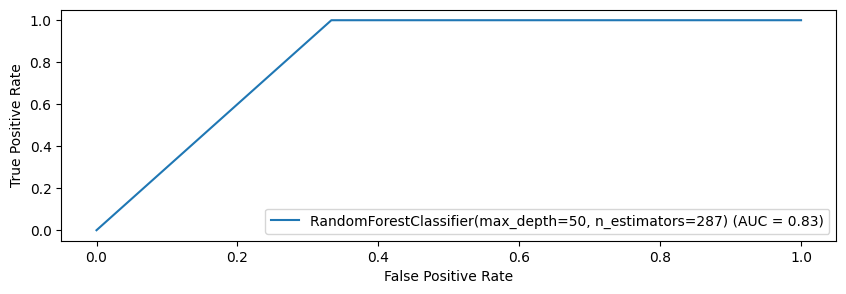

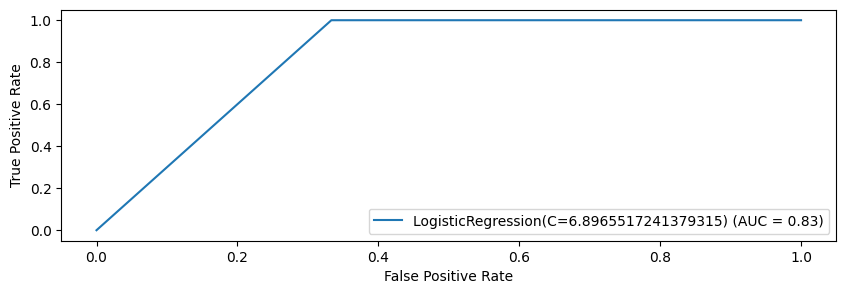

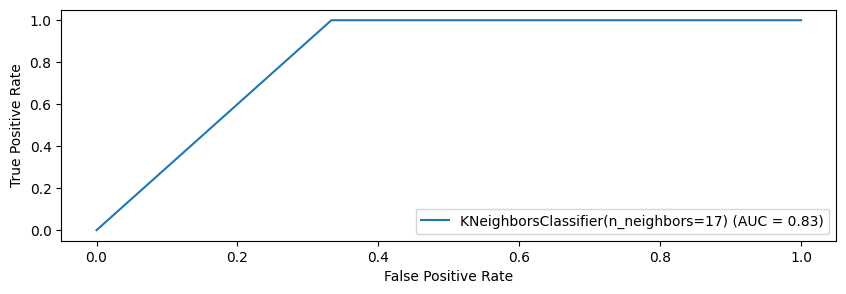

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

for model in chosen_models:
    model.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_size = auc(fpr, tpr)
    print(auc_size)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_size, estimator_name=model)
    display.plot()

plt.show()